# This colab is used to load rosbag and make a perception with Yolact and can store into hdf5 , image topic type of bag can be sensor/Image or sensor/CompressedImage.

# Install ROS

In [ ]:
%%bash
sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'
apt-key adv --keyserver 'hkp://keyserver.ubuntu.com:80' --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654
apt update  &> /dev/null
apt install ros-melodic-ros-base &> /dev/null

sudo rosdep init  &> /dev/null
rosdep update  &> /dev/null

apt install python-rosinstall  &> /dev/null
apt install python-catkin-tools  &> /dev/null
apt install ros-melodic-ros-numpy ros-melodic-vision-opencv &> /dev/null

Executing: /tmp/apt-key-gpghome.pvZYSElzg9/gpg.1.sh --keyserver hkp://keyserver.ubuntu.com:80 --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654


gpg: key F42ED6FBAB17C654: public key "Open Robotics <info@osrfoundation.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [ ]:
import sys
import os
import time

sys.path.append('/opt/ros/melodic/lib/python2.7/dist-packages/')
print(sys.path)

os.environ['PATH'] += ':/opt/ros/melodic/bin'
print(os.environ['PATH'])

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/Yolact-pytorch', '/opt/ros/melodic/lib/python2.7/dist-packages/']
/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/opt/ros/melodic/bin


In [ ]:
!pip install rospkg
!pip install pycryptodomex
!pip install gnupg

     |████████████████████████████████| 81kB 4.8MB/s 
     |████████████████████████████████| 13.7MB 249kB/s 
     |████████████████████████████████| 102kB 6.3MB/s 
  Created wheel for gnupg: filename=gnupg-2.3.1-cp36-none-any.whl size=94606 sha256=81d69554f4171e5fbc7d09cc5fa15122107b3cd62e151fbda4d363689d3ddff9
  Stored in directory: /root/.cache/pip/wheels/a8/7c/24/75dde86fabe7aa24e6e8146f20eccb2579c09ca6ad611a2630
Successfully built gnupg


In [ ]:
import re
import math
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import rosbag
import h5py
import ros_numpy
from sensor_msgs.msg import Image, PointCloud2, PointField
from cv_bridge import CvBridge, CvBridgeError
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Get immage from bag and store in list

In [ ]:
def get_image_list(height,weight,channels,bag_path,topic):
  imgs = []
  b = rosbag.Bag(bag_path,'r')
  for topic, msg, t in b.read_messages(topic):
      img = ros_numpy.image.image_to_numpy(msg)
      img = cv2.resize(img, (weight, height), interpolation=cv2.INTER_AREA)
      imgs.append(img)
  return imgs

Read image from hdf5 and store to list

In [ ]:
def read_img(path):
    f = h5py.File(path,'r')
    img_st = []
    for key in f.keys():
       print(key)
       print(f[key].name)
       print(f[key].shape)
       img_st.append(f[key].value)
    return img_st

Input image list and write to hdf5

In [ ]:
def write_hdf5(image,outfile):
    with h5py.File(outfile,'w') as f:      
        f['image'] = image

Example of sensor/Image

In [ ]:
import gdown
%cd /content/
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download'
dataset_name = 'rosbag'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content
/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download
To: /content/bags/rosbag.bag
1.58GB [00:13, 117MB/s] 


Finished downloading dataset.


Example of sensor/CompressedImage

In [ ]:
import gdown
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id=1rMNW2XnCyvs0EFh070yrGTEvLcGN_0MF&export=download'
dataset_name = 'a_lvl_2_split'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1rMNW2XnCyvs0EFh070yrGTEvLcGN_0MF&export=download
To: /content/bags/a_lvl_2_split.bag
862MB [00:06, 128MB/s]


Finished downloading dataset.


In [ ]:
Bag_path = '/content/bags'
bags = os.listdir(Bag_path)[::-1]
bags.sort()

Show rosbag informations

In [ ]:
for b_name in bags:
  if b_name != '.ipynb_checkpoints':
    print(rosbag.Bag(Bag_path+'/'+b_name))

If bag doesn't contain sensor/Image but sensor/CompressedImage , use this function to do converting compressedImage to image.

In [ ]:
bag_path = '/content/bags/a_lvl_2_split.bag'
topic = '/chinook/multisense/left/image_rect_color/compressed'

In [ ]:
def readImage(topic_name,bag_path):  
    bag  = rosbag.Bag(bag_path)
    lis = []

    bridge = CvBridge()

    for topic, msg, t in bag.read_messages(topics=topic_name):
        try:
            np_arr = np.fromstring(msg.data, np.uint8)
            cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
            lis.append(cv_image)
        except CvBridgeError as e:
            print('e')
    return lis

create hdf5 of topic

In [ ]:
temp = readImage(topic,bag_path)
write_hdf5(np.array(temp),'/content/compressdimage_data.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


read hdf5 file

In [ ]:
output_file = '/content/compressdimage_data.hdf5'
compressed_Img = read_img(output_file)

image
/image
(300, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


randomly show

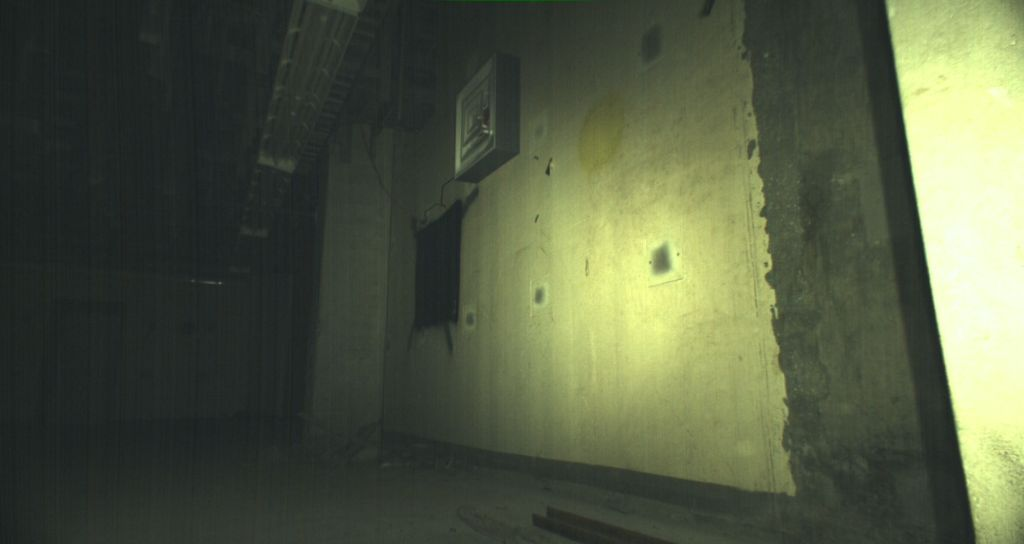

In [ ]:
compressed_image_list = np.array(compressed_Img)
cv2_imshow(compressed_image_list[0][260])

If bag contain sensor/Image.

In [ ]:
bag_path = '/content/bags/rosbag.bag'
topic = '/camera/color/image_raw'

create hdf5 of topic

In [ ]:
Image = get_image_list(256,256,3,bag_path,topic)
write_hdf5(Image,'/content/Image_data.hdf5')

read hdf5 file

In [ ]:
output_file = '/content/Image_data.hdf5'
Img = read_img(output_file)

image
/image
(1029, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


randomly show

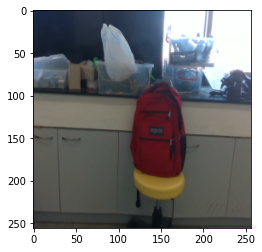

In [ ]:
image_list = np.array(Img)
plt.imshow(image_list[0][0])

Define Yolact model

In [ ]:
%cd /content
import os
sys.path.append('/content/Yolact-pytorch')
!git clone https://github.com/ARG-NCTU/Yolact-pytorch.git
!pip install tensorboardX
!pip install terminaltables

In [ ]:
import sys
import numpy as np
import cv2

import struct
import time
import os
import math
import argparse

import PIL
import pandas as pd
import scipy.misc
import random
from cv_bridge import CvBridge, CvBridgeError
# from std_msgs.msg import Header
from datetime import datetime

from torchvision import transforms, utils, datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import models
from torchvision.models.vgg import VGG
# from sklearn.metrics import confusion_matrix
# from subt_msgs.msg import *

import torch.backends.cudnn as cudnn
from modules.build_yolact import Yolact
from utils.augmentations import FastBaseTransform
from utils.functions import MovingAverage, ProgressBar
from utils import timer
from data.config import update_config, COLORS, cfg
from utils.output_utils import NMS, after_nms, draw_img

import pyximport
pyximport.install(setup_args={"include_dirs": np.get_include()}, reload_support=True)

/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Yolact-pytorch/utils/cython_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


(None, None)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
import sys
import logging
import gdown
from zipfile import ZipFile
%cd /content
dataset_url = "https://drive.google.com/u/1/uc?id=1OR36Mmu252_rkUo9bEgk4tx71J2ZwbGd&export=download"
dataset_name = "2_latest_res101_custom_800001"
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.pth', quiet=False)

print("Finished downloading dataset.")

/content


Downloading...
From: https://drive.google.com/u/1/uc?id=1OR36Mmu252_rkUo9bEgk4tx71J2ZwbGd&export=download
To: /content/2_latest_res101_custom_800001.pth
199MB [00:01, 112MB/s]


Finished downloading dataset.


In [ ]:
model_name = '/content/2_latest_res101_custom_800001.pth'
strs = model_name.split('_')
config = strs[-3] + "_" + strs[-2] + "_config"
update_config(config)
cuda = torch.cuda.is_available()
if cuda:
  cudnn.benchmark = True
  cudnn.fastest = True
  torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
  torch.set_default_tensor_type('torch.FloatTensor')

net = Yolact()
net.load_weights(model_name, cuda)
net.cuda()

In [ ]:
parser = argparse.ArgumentParser(description='YOLACT Predict in ROS')
parser.add_argument('--visual_top_k', default=100, type=int, help='Further restrict the number of predictions to parse')
parser.add_argument('--traditional_nms', default=False, action='store_true', help='Whether to use traditional nms.')
parser.add_argument('--hide_mask', default=False, action='store_true', help='Whether to display masks')
parser.add_argument('--hide_bbox', default=True, action='store_true', help='Whether to display bboxes')
parser.add_argument('--hide_score', default=True, action='store_true', help='Whether to display scores')
parser.add_argument('--show_lincomb', default=False, action='store_true',
							help='Whether to show the generating process of masks.')
parser.add_argument('--no_crop', default=False, action='store_true',
							help='Do not crop output masks with the predicted bounding box.')
parser.add_argument('--real_time', default=True, action='store_true', help='Show the detection results real-timely.')
parser.add_argument('--visual_thre', default=0.3, type=float,help='Detections with a score under this threshold will be removed.')
args = parser.parse_args(args=['--visual_top_k', '100','--traditional_nms','--hide_mask','--hide_bbox','--show_lincomb','--no_crop','--real_time','--visual_thre','0.3'])

In [ ]:
args.hide_mask = False
args.no_crap = False
args.traditional_nms = False
args.hide_bbox = False

In [ ]:
print(args)

Namespace(hide_bbox=False, hide_mask=False, hide_score=True, no_crap=False, no_crop=True, real_time=True, show_lincomb=True, traditional_nms=False, visual_thre=0.3, visual_top_k=100)


Run perception

In [ ]:
def predictor(img):
  rgb_origin = img
  img_numpy = img

  img = torch.from_numpy(img.copy()).float()
  img = img.cuda()

  img_h, img_w = img.shape[0], img.shape[1]
  img_trans = FastBaseTransform()(img.unsqueeze(0))

  net_outs = net(img_trans)
  nms_outs = NMS(net_outs, 0)

  results = after_nms(nms_outs, img_h, img_w, crop_masks=not args.no_crop, visual_thre=args.visual_thre)
  # print(results)
  masks = results[3][:args.visual_top_k]
  torch.cuda.synchronize()
  frame_numpy = draw_img(results, img, args, class_color=True, fps=0)

  return frame_numpy,masks

In [ ]:
def perception(data):
  Result = []
  num = data.shape[1]
  for i in range(num):
    predict_img = predictor(data[0][i])
    print('Frame : ',i,'\n')
    Result.append(predict_img)
    plt.figure(figsize=(15,15))
    plt.imshow(predict_img[:,:,[2,1,0]])
    plt.show()
    # cv2_imshow(predict_img)
  return Result

Image bag

In [ ]:
result_1 = perception(image_list)

compressed image bag

In [ ]:
result_2 = perception(compressed_image_list) 

Output hidden; open in https://colab.research.google.com to view.

Store result to hdf5

In [ ]:
write_hdf5(result_1,'/content/result_1.hdf5')

In [ ]:
write_hdf5(result_2,'/content/result_Yolact_vent_box.hdf5')

read hdf5

In [ ]:
output_file_ = '/content/result_1.hdf5'
result_ = read_img(output_file_)

image
/image
(1029, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


In [ ]:
output_file = '/content/result_Yolact_vent_box.hdf5'
result__ = read_img(output_file)

image
/image
(300, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


show image

In [ ]:
cv2_imshow(result_[0][54])

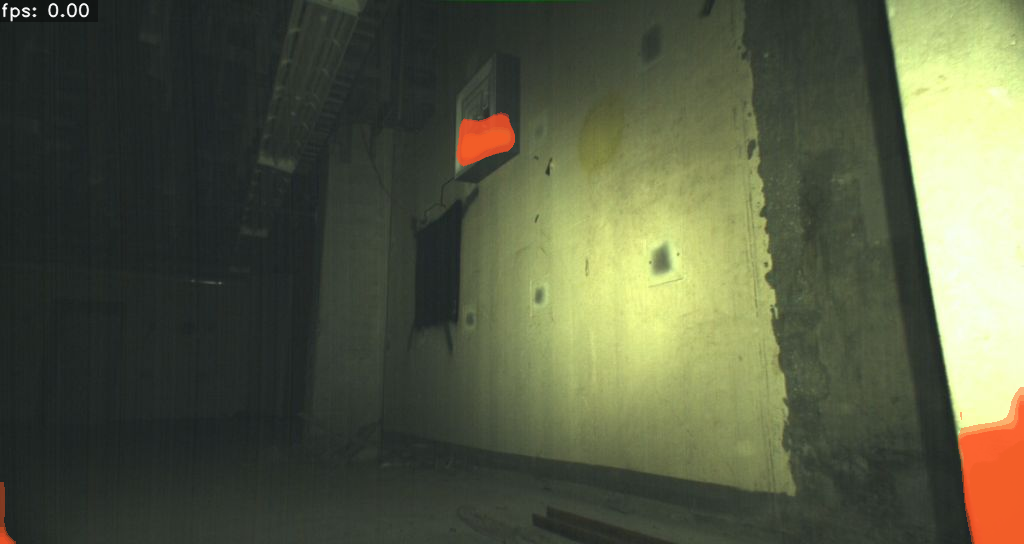

In [ ]:
cv2_imshow(result__[0][260])